In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt


from pathlib import Path
import sys
parent_dir = Path().resolve().parent
sys.path.insert(0, str(parent_dir))
from libs.functions import *

In [ ]:
df = pd.read_csv('data/predictions.csv')
df.rename(columns={'Unnamed: 0': 'index_original'}, inplace=True)

,index_original,period,timestamp,ticker,y_true,discount,Naïve,OLS,LASSO,MLP,MLP-Pyr,discount_month,y_true_full,Naïve_full,OLS_full,LASSO_full,MLP_full,MLP-Pyr_full
0,228,21,2021-01-31,AAB.CO,0.004785,0.0000,0.008812,0.014568,0.026861,0.022544,0.016144,0.000000,0.004785,0.008812,0.014568,0.026861,0.022544,0.016144
1,229,21,2021-02-28,AAB.CO,-0.028571,0.0000,0.008812,0.022468,0.028238,0.021499,0.016413,0.000000,-0.028571,0.008812,0.022468,0.028238,0.021499,0.016413
2,230,21,2021-03-31,AAB.CO,-0.009804,0.0000,0.008812,0.041455,0.025399,0.020335,0.017362,0.000000,-0.009804,0.008812,0.041455,0.025399,0.020335,0.017362
3,231,21,2021-04-30,AAB.CO,0.084158,0.0000,0.008812,0.032088,0.024087,0.016490,0.010342,0.000000,0.084158,0.008812,0.032088,0.024087,0.016490,0.010342
4,232,21,2021-05-31,AAB.CO,-0.068493,0.0000,0.008812,0.028618,0.021055,0.015101,0.007152,0.000000,-0.068493,0.008812,0.028618,0.021055,0.015101,0.007152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,45570,24,2024-08-31,ZELA.CO,-0.085660,0.0335,0.008954,0.012422,0.046373,0.012966,0.013060,0.002750,-0.082910,0.011704,0.015172,0.049123,0.015715,0.015810
5955,45571,24,2024-09-30,ZELA.CO,-0.030425,0.0310,0.008954,-0.051152,0.038206,0.013133,0.010812,0.002547,-0.027878,0.011502,-0.048605,0.040753,0.015681,0.013360
5956,45572,24,2024-10-31,ZELA.CO,-0.079081,0.0285,0.008954,-0.050271,0.039111,0.014784,0.009792,0.002344,-0.076737,0.011299,-0.047927,0.041455,0.017128,0.012136
5957,45573,24,2024-11-30,ZELA.CO,-0.022208,0.0285,0.008954,-0.001312,0.031701,0.011581,0.005026,0.002344,-0.019863,0.011299,0.001032,0.034046,0.013926,0.007370


In [ ]:
# create deciles
df['decile_ols'] = df.groupby(['timestamp'])['OLS'].transform(deciles)
df['decile_mlp'] = df.groupby(['timestamp'])['MLP'].transform(deciles)
df['decile_lasso'] = df.groupby(['timestamp'])['LASSO'].transform(deciles)
df['decile_mlp-pyr'] = df.groupby(['timestamp'])['MLP-Pyr'].transform(deciles)
df['decile_naive'] = 9


In [90]:
# calculate portfolio returns
df.sort_values(by=['timestamp'])
all = pd.DataFrame()
models = {
    # 'naive':    'decile_naive',
    'ols':      'decile_ols',
    'lasso':    'decile_lasso',
    'mlp':      'decile_mlp',
    'mlp_pyr':  'decile_mlp-pyr'
}

tmp_dfs = {}

for model, decile in models.items():
    tmp = df.copy(deep=True)
    tmp = tmp[['timestamp', 'ticker', decile, 'y_true_full']]

    tmp['action'] = np.where(tmp[decile] == 0, -1, np.where(tmp[decile] == 9, 1, 0))

    tmp['n_short'] = (tmp['action'] == -1).astype(int)
    tmp['n_long'] = (tmp['action'] == 1).astype(int)


    tmp['n_short'] = tmp.groupby('timestamp')['n_short'].transform('sum')
    tmp['n_long'] = tmp.groupby('timestamp')['n_long'].transform('sum')

    tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],
                            np.where(tmp['action'] == -1, tmp['y_true_full']/tmp['n_short'], 0))
    # tmp[f'{model}_return'] = np.where(tmp['action'] == 1, tmp['y_true_full']/tmp['n_long'],0)
    # tmp[f'{model}_return'] = np.where(tmp['action'] == -1, tmp['y_true_full']/tmp['n_short'],0)

    tmp_df = tmp.copy(deep=True)
    # drop rows with action == 0
    tmp_df = tmp_df[tmp_df['action'] != 0]
    tmp_dfs[model] = tmp_df
    
    tmp = tmp.groupby('timestamp')[f'{model}_return'].sum().reset_index()
    tmp[f'{model}_return'] = tmp[f'{model}_return'] + 1
    tmp[f'{model}_return_cum'] = tmp[f'{model}_return'].cumprod() * 100
    tmp[f'{model}_return'] = tmp[f'{model}_return'] - 1

    all = pd.concat([all, tmp], axis=1)
all = all.loc[:, ~all.columns.duplicated()]
all

,timestamp,ols_return,ols_return_cum,lasso_return,lasso_return_cum,mlp_return,mlp_return_cum,mlp_pyr_return,mlp_pyr_return_cum
0,2021-01-31,0.100943,110.094338,0.162788,116.278792,0.122447,112.244744,0.124309,112.430860
1,2021-02-28,0.086072,119.570407,0.135135,131.992114,0.128993,126.723506,0.098919,123.552439
2,2021-03-31,0.092970,130.686836,0.160203,153.137620,0.113366,141.089607,0.169071,144.441572
3,2021-04-30,0.004645,131.293934,0.004534,153.831870,0.020734,144.014939,0.013621,146.409034
4,2021-05-31,0.076642,141.356515,0.022669,157.319016,0.044200,150.380406,0.024843,150.046277
5,2021-06-30,-0.001592,141.131539,0.041124,163.788659,0.015353,152.689232,0.037789,155.716407
6,2021-07-31,0.039328,146.681978,0.000016,163.791283,0.035913,158.172759,0.059787,165.026250
7,2021-08-31,-0.086993,133.921696,-0.132562,142.078796,-0.076919,146.006198,-0.104111,147.845167
8,2021-09-30,0.030892,138.058820,0.068005,151.740853,0.037722,151.513790,0.057857,156.399068
9,2021-10-31,-0.130507,120.041192,-0.141421,130.281450,-0.093494,137.348167,-0.140910,134.360857


In [99]:

# display on april 2022
tmp_dfs['ols'].loc[tmp_dfs['ols']['timestamp'] == '2022-04-30']

,timestamp,ticker,decile_ols,y_true_full,action,n_short,n_long,ols_return
15,2022-04-30,AAB.CO,9,-0.172131,1,13,13,-0.013241
255,2022-04-30,AMBUb.CO,0,0.005295,-1,13,13,0.000407
352,2022-04-30,ATLA.CO,0,0.728111,-1,13,13,0.056009
400,2022-04-30,BAVA.CO,0,0.532745,-1,13,13,0.040980
498,2022-04-30,BIOPOR.CO,0,-0.060241,-1,13,13,-0.004634
844,2022-04-30,CHRH.CO^A24,0,-0.060398,-1,13,13,-0.004646
880,2022-04-30,COLOb.CO,9,-0.135349,1,13,13,-0.010411
976,2022-04-30,CPHCAPST.CO,0,-0.116129,-1,13,13,-0.008933
1360,2022-04-30,DRLCO.CO^J22,0,0.118644,-1,13,13,0.009126
1960,2022-04-30,GJ.CO,9,-0.018987,1,13,13,-0.001461


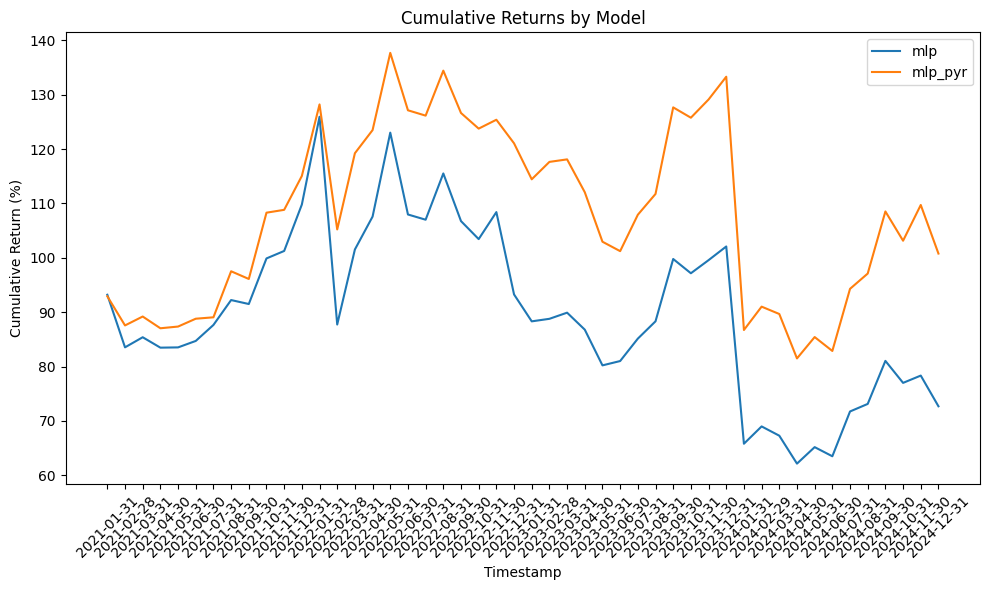

In [75]:
# plotting
plt.figure(figsize=(10, 6))
for model in models.keys():
    plt.plot(all['timestamp'], all[f'{model}_return_cum'], label=model)
plt.title('Cumulative Returns by Model')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()